In [1]:
import pandas as pd
import seaborn as sns
import warnings
sns.set_palette('Pastel1')
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

In [2]:
dat = pd.read_csv('/Users/victoriashi/Downloads/us-covid-imputed-data.csv', parse_dates=True)
dat['date'] = pd.to_datetime(dat['date'], format='%m/%d/%y')

In [3]:
# dat.head()

In [30]:
#extract month and year from date
dat['month'] = dat['date'].dt.month
dat['year'] = dat['date'].dt.year

In [31]:
# aggregate by the column state_name and produce a new dataframe
dat_state = dat.groupby('state_name')
dat.drop('county_name', axis=1, inplace=True)

KeyError: "['county_name'] not found in axis"

In [ ]:
dat.head()

## 2. Data Preprocessing

Separate data into the specified regions

In [32]:
# Define the states in each region
regions = {
    'Northwest': ['Washington', 'Oregon', 'Idaho', 'Montana', 'Wyoming'],
    'Southwest': ['Arizona', 'New Mexico', 'Oklahoma', 'Texas'],
    'Midwest': ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota',
                'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'],
    'South': ['Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky',
              'Louisiana', 'Maryland', 'Mississippi', 'North Carolina', 'South Carolina',
              'Tennessee', 'Virginia', 'West Virginia'],
    'Great Lakes': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
    'New England': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
}

# Create separate dataframes for each region and set 'date' as the index
Northwest = dat[dat['state_name'].isin(regions['Northwest'])].set_index('date')
Southwest = dat[dat['state_name'].isin(regions['Southwest'])].set_index('date')
Midwest = dat[dat['state_name'].isin(regions['Midwest'])].set_index('date')
South = dat[dat['state_name'].isin(regions['South'])].set_index('date')
Great_Lakes = dat[dat['state_name'].isin(regions['Great Lakes'])].set_index('date')
New_England = dat[dat['state_name'].isin(regions['New England'])].set_index('date')

In [39]:
Midwest.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/Midwest.csv')

### Aggregate data by month

In [63]:
# Function to aggregate monthly confirmed cases for a given dataframe
def aggregate_monthly(df):
    monthly_df = df.groupby([df.year, df.month]).agg({'covid_19_confirmed_cases':'sum'}).reset_index()
    monthly_df.columns = ['Year', 'Month', 'Monthly_Confirmed_Cases']
    monthly_df['Date'] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(DAY=1))
    monthly_df = monthly_df.set_index('Date')
    return monthly_df

# Apply the aggregation to each region
Northwest_monthly = aggregate_monthly(Northwest)
Southwest_monthly = aggregate_monthly(Southwest)
Midwest_monthly = aggregate_monthly(Midwest) 
South_monthly = aggregate_monthly(South)
Great_Lakes_monthly = aggregate_monthly(Great_Lakes)
New_England_monthly = aggregate_monthly(New_England)

KeyError: "Column(s) ['covid_19_confirmed_cases'] do not exist"

### store each state's data as csv file

In [12]:
import os
#check if dir exists
if not os.path.exists('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data'):
    os.mkdir('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data')
    print(f"Created Directory VS_processed_region_data")
    Northwest_monthly.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/Northwest_monthly.csv')
    Southwest_monthly.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/Southwest_monthly.csv')
    Midwest_monthly.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/Midwest_monthly.csv')
    South_monthly.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/South_monthly.csv')
    Great_Lakes_monthly.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/Great_Lakes_monthly.csv')
    New_England_monthly.to_csv('/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/New_England_monthly.csv')
    print(f"Generated regional data in csv format")
else:
    print(f"Directory VS_processed_region_data already exists")

Directory VS_processed_region_data already exists


# Visualize the time series

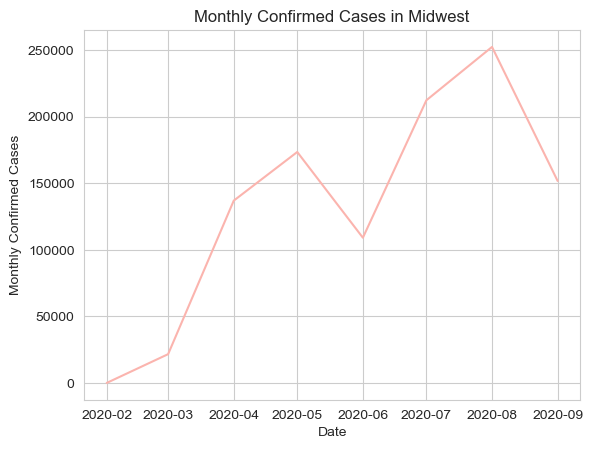

In [40]:
# Visualize the time series data
plt.plot(Midwest_monthly['Monthly_Confirmed_Cases'])
plt.title('Monthly Confirmed Cases in Midwest')
plt.ylabel('Monthly Confirmed Cases')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [16]:
# 2. Check for Stationarity using ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')

In [17]:
adf_test(Midwest_monthly['Monthly_Confirmed_Cases'])

ADF Statistic: -3.3520876338812013
p-value: 0.012704755387211804
1%: -5.354256481481482
5%: -3.6462381481481483
10%: -2.901197777777778


In [18]:
# 3. Stationarize the Series
Midwest_monthly['Differenced_Data'] = Midwest_monthly['Monthly_Confirmed_Cases'].diff()
Midwest_monthly.dropna(inplace=True)

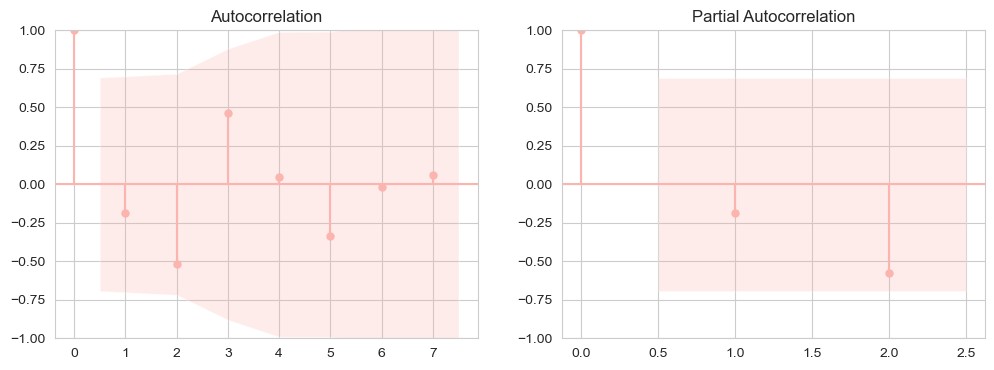

In [19]:
# 4. Determine ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(Midwest_monthly['Differenced_Data'], ax=ax[0])
plot_pacf(Midwest_monthly['Differenced_Data'], ax=ax[1], lags=2)
plt.show()

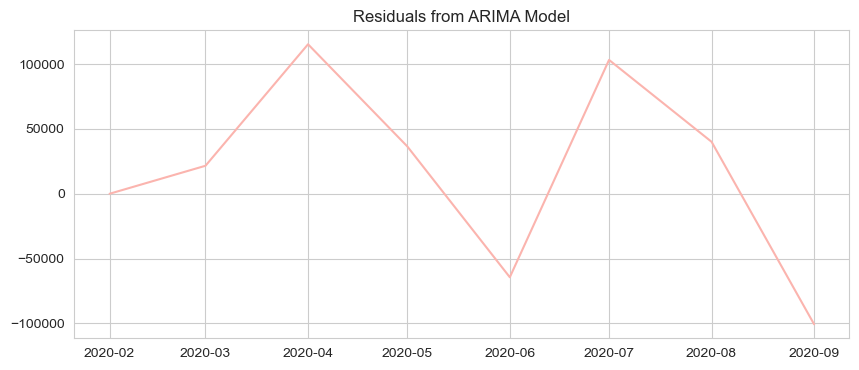

In [20]:
# 5. Fit ARIMA model
Midwest_monthly = Midwest_monthly.asfreq('MS')
# Given the small dataset, start with a simpler model
model = ARIMA(Midwest_monthly['Monthly_Confirmed_Cases'], order=(0,1,0))
model_fit = model.fit()

# Check the residuals
residuals = model_fit.resid
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

# Plot the ACF of residuals
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(residuals)
# plt.show()

In [21]:
# Resample original data to weekly frequency (Sunday is considered the start of the week)
Midwest_weekly = Midwest.resample('W-SUN').agg({'covid_19_confirmed_cases':'sum'})
Midwest_weekly.head()

,covid_19_confirmed_cases
date,
2020-01-26,1.0
2020-02-02,1.0
2020-02-09,0.0
2020-02-16,0.0
2020-02-23,0.0


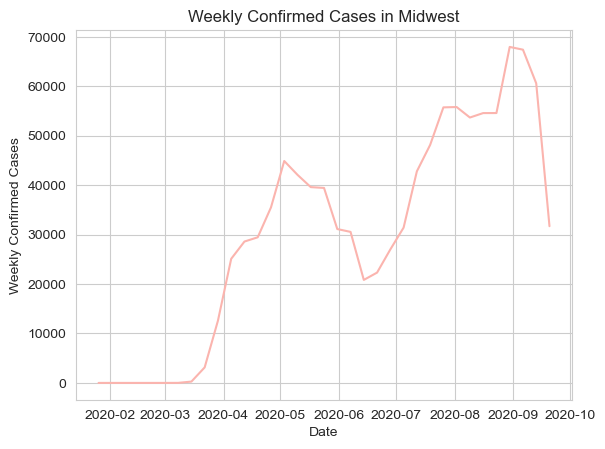

In [22]:
plt.plot(Midwest_weekly['covid_19_confirmed_cases'])
plt.title('Weekly Confirmed Cases in Midwest')
plt.ylabel('Weekly Confirmed Cases')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [23]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')

adf_test(Midwest_weekly['covid_19_confirmed_cases'])

ADF Statistic: -2.0623738106735816
p-value: 0.25991083604179266
1%: -3.6461350877925254
5%: -2.954126991123355
10%: -2.6159676124885216


The p-value is 0.2599, which is greater than the common significance levels (0.01, 0.05, or 0.10). Typically, a p-value less than 0.05 would be evidence against the null hypothesis, and we would conclude that the time series is stationary. However, in this case, the p-value is higher, which means we fail to reject the null hypothesis of the ADF test, implying the time series has a unit root and is non-stationary.

The ADF Statistic of -2.0624 is greater than the critical values provided for 1%, 5%, and 10% significance levels. This further confirms that the series is non-stationary.

In [24]:
Midwest_weekly['Differenced_Data'] = Midwest_weekly['covid_19_confirmed_cases'].diff()
Midwest_weekly.dropna(inplace=True)

In [25]:
adf_test(Midwest_weekly['Differenced_Data'])

ADF Statistic: -1.8496137598968458
p-value: 0.356122605991016
1%: -3.6461350877925254
5%: -2.954126991123355
10%: -2.6159676124885216


In [26]:
# Apply second-order differencing
Midwest_weekly['Second_Differenced_Data'] = Midwest_weekly['covid_19_confirmed_cases'].diff().diff()
Midwest_weekly.dropna(inplace=True)

# Check for stationarity again
adf_test(Midwest_weekly['Second_Differenced_Data'])

ADF Statistic: -5.703656423174144
p-value: 7.574724996858348e-07
1%: -3.661428725118324
5%: -2.960525341210433
10%: -2.6193188033298647


The p-value significantly smaller than 0.05, indicating strong evidence against the null hypothesis of the ADF test. 
Reject the null hypothesis and conclude the time series after 2nd difference it's stationary.

The ADF Statistic of -5.5083 is smaller than the critical values at the 1%, 5%, and 10% significance levels, further supporting that the series is stationary.

### fit an ARIMA model with d=2

In [27]:
# Fit the ARIMA model with d=2
weekly_model = ARIMA(Midwest_weekly['covid_19_confirmed_cases'], order=(1,2,0)).fit()
print(weekly_model.summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                   32
Model:                       ARIMA(1, 2, 0)   Log Likelihood                -310.278
Date:                      Fri, 13 Oct 2023   AIC                            624.557
Time:                              11:13:41   BIC                            627.359
Sample:                          02-16-2020   HQIC                           625.453
                               - 09-20-2020                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2117      0.199     -1.064      0.288      -0.602       0.178
sigma2      5.827e+07   1.08e-09   5.42e+16      0.000    5.83e+07    5.83e+07
Ljun

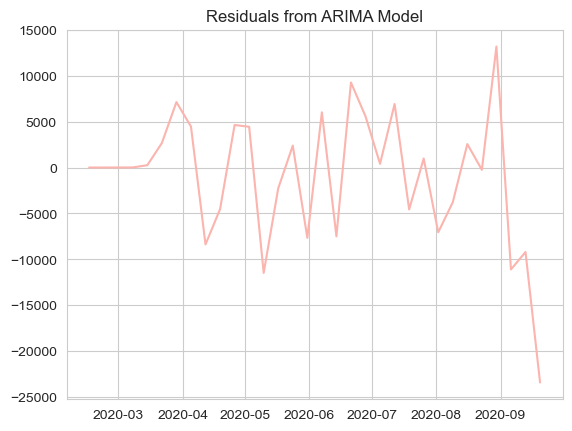

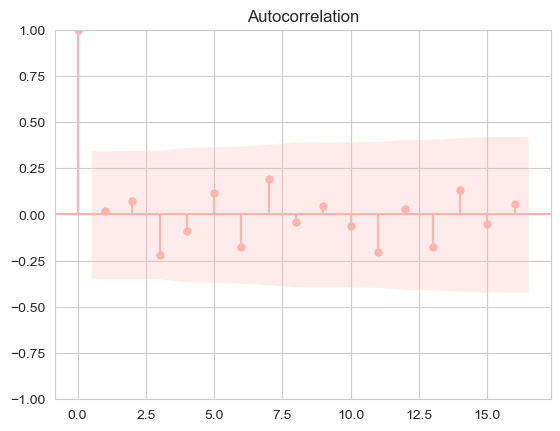

In [28]:
residuals = weekly_model.resid
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

# ACF plot of residuals to check for any autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()

In [29]:
model_121 = ARIMA(Midwest_weekly['covid_19_confirmed_cases'], order=(1,2,1)).fit()
print(model_121.summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                   32
Model:                       ARIMA(1, 2, 1)   Log Likelihood                -310.069
Date:                      Fri, 13 Oct 2023   AIC                            626.138
Time:                              11:13:41   BIC                            630.342
Sample:                          02-16-2020   HQIC                           627.483
                               - 09-20-2020                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6239      0.447     -1.395      0.163      -1.501       0.253
ma.L1          0.4081      0.493      0.827      0.408      -0.559       1.375
sigm

In [30]:
# Train-test split
train = Midwest_weekly['covid_19_confirmed_cases'][:-12]  # Using last 12 weeks as test set
test = Midwest_weekly['covid_19_confirmed_cases'][-12:]
model_train = ARIMA(train, order=(1,2,0)).fit()


In [31]:
forecast = model_train.forecast(steps=12)


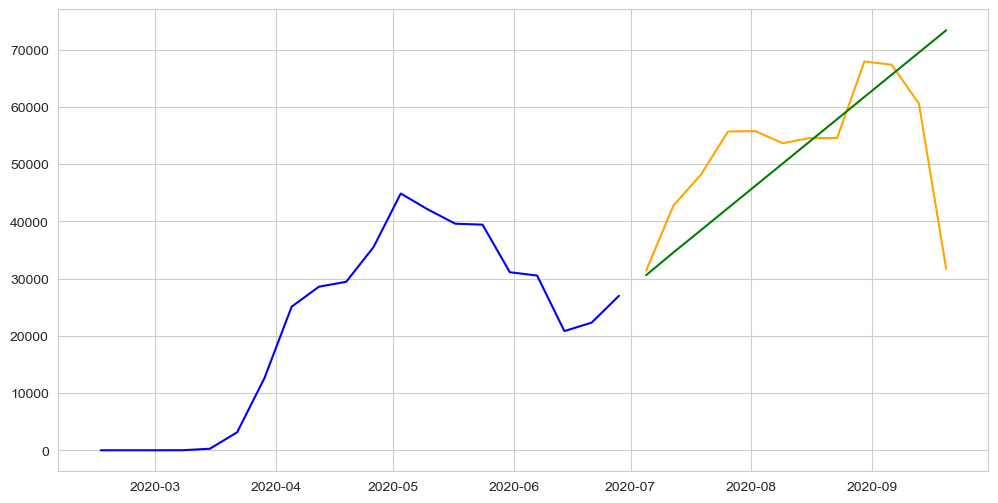

In [32]:
# Plot actual vs forecasted values
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')

In [33]:
weekly_model020 = ARIMA(Midwest_weekly['covid_19_confirmed_cases'], order=(0,2,0)).fit()
print(weekly_model020.summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                   32
Model:                       ARIMA(0, 2, 0)   Log Likelihood                -310.795
Date:                      Fri, 13 Oct 2023   AIC                            623.589
Time:                              11:13:41   BIC                            624.990
Sample:                          02-16-2020   HQIC                           624.037
                               - 09-20-2020                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.458e+07   1.13e+07      4.822      0.000    3.24e+07    7.68e+07
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                 2.15

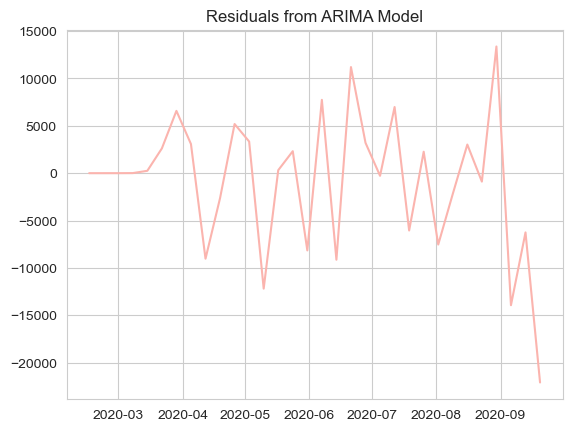

In [34]:
residuals = weekly_model020.resid
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()